In [12]:
!git clone 'https://github.com/Lorenz92/SKADC1.git'
% cd SKADC1
!echo $PWD

Cloning into 'SKADC1'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 41 (delta 17), reused 25 (delta 6), pack-reused 0
Unpacking objects: 100% (41/41), done.


In [51]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import sys
from astropy.io import fits
import os

import src.dataset as dataset
import src.config as config
from src.utils import *

# from src.config import * 

%load_ext autoreload
%autoreload 2

np.random.seed(config.RANDOM_SEED)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
for download_info in config.required_files:
    if not os.path.exists(download_info['file_name']):
        download_data(download_info['file_name'], download_info['url'], config.DOWNLOAD_FOLDER)


Download completed!
Download completed!
Download completed!


In [5]:
# Dataset parsing and loading
# use "subset" to load a small portion of data for development/debugging purposes

ska_dataset = dataset.SKADataset(train_set_path=config.TRAIN_SET_PATH, subset=config.DATA_SUBSET)
print(ska_dataset.raw_train_df.shape)
ska_dataset.raw_train_df.head()

(27488, 15)


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,SIZE,CLASS,SELECTION,x,y
0,20125271,-0.306736,-29.819586,-0.306736,-29.819586,3.857740e-07,-0.0,0.169,0.048,-51.305,2,3,1,17968.506,17455.751
1,21474507,-0.461378,-29.677727,-0.461378,-29.677727,1.619710e-07,-0.0,0.093,0.037,-25.572,2,3,1,18771.204,18298.228
2,18231864,-0.339760,-29.773502,-0.339760,-29.773502,8.238160e-08,-0.0,0.736,0.486,45.094,2,3,0,18140.009,17729.824
3,18020616,-0.663926,-29.528933,-0.663926,-29.528933,1.388550e-07,-0.0,0.102,0.080,-33.803,2,3,1,19824.674,19179.532
4,32375089,-0.561167,-29.684151,-0.561167,-29.684151,4.389060e-08,-0.0,0.218,0.190,-55.759,2,3,0,19287.533,18257.651


In [47]:
data_560Mhz_1000h_fits = fits.open('./data/training/560Mhz_1000h.fits')
# data_560Mhz_1000h_fits.info()
data_560Mhz_1000h_fits.filename()

# print(data_560Mhz_1000h_fits[0].data)
# print(data_560Mhz_1000h_fits[0].data.shape)

# data_560Mhz_1000h = data_560Mhz_1000h_fits[0].data[0,0]


'./data/training/560Mhz_1000h.fits'

In [7]:
data_560Mhz_1000h_fits[0].header

SIMPLE  =                    T  /                                               
BITPIX  =                  -32  /                                               
NAXIS   =                    4  /                                               
NAXIS1  =                32768  /                                               
NAXIS2  =                32768  /                                               
NAXIS3  =                    1  /                                               
NAXIS4  =                    1  /                                               
EXTEND  =                    T  /                                               
BSCALE  =    1.00000000000E+00  /                                               
BZERO   =    0.00000000000E+00  /                                               
BLANK   =                   -1  /                                               
BUNIT   = 'JY/BEAM '  /                                                         
DATE-OBS= '2000-01-01T12:00:

In [9]:
# Visualization test
from astropy.io import fits
from astropy.utils.data import download_file

# image_file = download_file('https://owncloud.ia2.inaf.it/index.php/s/hbasFhd4YILNkCr/download', cache=True )

# image_data = fits.getdata(image_file)
# image_data = image_data.reshape(image_data.shape[2:])

# compute per value to clip the image
perc = 99.9
percentileThresh = np.percentile(data_560Mhz_1000h, perc)
print (f'{perc} percentile {percentileThresh}')

# # crop the image to speed up computation and clip using per value
# image_crop= image_data[5000:10000, 5000:10000]
# image_crop.clip(max=percentileThresh)

# plt.figure(figsize=(100, 100))
# # plt.imshow(normalized_data, cmap='viridis', vmax=255, vmin=0)
# for idx in range(25):
#     plt.subplot(5, 5, idx+1)
#     plt.axis('off')
#     base = 200 * idx
#     end = base + 200
#     normalized_data = image_crop[base:end, base:end] * (1.0 / percentileThresh)
#     plt.imshow(normalized_data, cmap='viridis', vmax=1, vmin=0)

99.9 percentile 8.316711500810925e-06


### Preprocessing

In [12]:
data_560Mhz_1000h_train = data_560Mhz_1000h[16000:20000, 16000:20000]


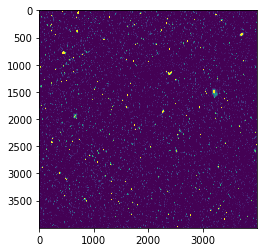

In [13]:
plt.imshow(data_560Mhz_1000h_train, cmap='viridis', vmax=1, vmin=0)

In [35]:
coords = ska_dataset._convert_boxes_to_px_coord(ska_dataset.raw_train_df, data_560Mhz_1000h_fits[0].header)
print(coords['x1'][0])

17634.567951719182


In [36]:
pd.DataFrame.from_dict(coords)

,x1,y1,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height
0,17634.567952,17052.785652,18302.437041,17858.712643,-503.434676,-142.987363,-0.895441,667.869089,805.926991
1,18516.810691,18142.709362,19025.588187,18453.738296,-277.038017,-110.219426,-0.446316,508.777496,311.028934
2,16283.393479,15870.815312,19996.616803,19588.826673,-2192.472907,-1447.747055,0.787039,3713.223324,3718.011361
3,19539.489182,18919.161565,20109.844845,19439.891976,-303.848147,-238.312272,-0.589974,570.355663,520.730411
4,18693.858772,17633.447416,19881.195643,18881.847861,-649.400943,-565.991647,-0.973178,1187.336871,1248.400445
...,...,...,...,...,...,...,...,...,...
27483,17150.809606,19753.797034,17574.471126,19995.681283,-214.481045,-116.177233,0.187536,423.661519,241.884249
27484,16308.266765,17832.211642,16988.016281,18665.848658,-417.046477,-339.594988,1.513811,679.749516,833.637016
27485,17577.153508,16694.083007,18524.392359,17331.646242,-473.645642,-318.742664,-0.014224,947.238851,637.563235
27486,16451.605902,11318.572770,20142.843819,24951.453083,-6899.140288,-1507.325123,-1.411936,3691.237917,13632.880313


In [37]:
df_train = ska_dataset._extend_dataframe(ska_dataset.raw_train_df, coords)
df_train.head()

,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,...,y,x1,y1,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height
0,20125271,-0.306736,-29.819586,-0.306736,-29.819586,3.857740e-07,-0.0,0.169,0.048,-51.305,...,17455.751,17634.567952,17052.785652,18302.437041,17858.712643,-503.434676,-142.987363,-0.895441,667.869089,805.926991
1,21474507,-0.461378,-29.677727,-0.461378,-29.677727,1.619710e-07,-0.0,0.093,0.037,-25.572,...,18298.228,18516.810691,18142.709362,19025.588187,18453.738296,-277.038017,-110.219426,-0.446316,508.777496,311.028934
2,18231864,-0.339760,-29.773502,-0.339760,-29.773502,8.238160e-08,-0.0,0.736,0.486,45.094,...,17729.824,16283.393479,15870.815312,19996.616803,19588.826673,-2192.472907,-1447.747055,0.787039,3713.223324,3718.011361
3,18020616,-0.663926,-29.528933,-0.663926,-29.528933,1.388550e-07,-0.0,0.102,0.080,-33.803,...,19179.532,19539.489182,18919.161565,20109.844845,19439.891976,-303.848147,-238.312272,-0.589974,570.355663,520.730411
4,32375089,-0.561167,-29.684151,-0.561167,-29.684151,4.389060e-08,-0.0,0.218,0.190,-55.759,...,18257.651,18693.858772,17633.447416,19881.195643,18881.847861,-649.400943,-565.991647,-0.973178,1187.336871,1248.400445


In [55]:
data_560Mhz_1000h_fits.filename()

33

In [72]:
patches={}
patches = split_in_patch(data_560Mhz_1000h_train, df_train, data_560Mhz_1000h_fits.filename(), 200)
print(len(patches))
# plt.imshow(patches[0] * (1.0 / percentileThresh), cmap='viridis', vmax=1, vmin=0)
# plt.imshow(patches[10] , cmap='viridis')

4


In [ ]:
# First net version
from tensorflow import keras

FROZEN_LAYERS_IDX = [1, 2, 4, 5]
ANCHOR_NUM = 9
PROB_PRED_OUT = 2 * ANCHOR_NUM
COORD_PRED_OUT = 4 * ANCHOR_NUM 

# Load pretrained VGG16 and remove last MaxPool layer
VGG16 = keras.applications.VGG16(include_top=False, input_shape=(600, 600, 3), weights="imagenet")
shared_conv = keras.Model(VGG16.input, VGG16.layers[-2].output, name="Shared Convolutional Net")

# Freeze first 4 convolutional layers
for idx in FROZEN_LAYERS_IDX:
  shared_conv.layers[idx].trainable = False

# Create Region Proposal Net
x = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', name='RPN_Conv1')(shared_conv.output)
cls_pred = keras.layers.Conv2D(filters=PROB_PRED_OUT, kernel_size=(1, 1), padding='same', name='RPN_Cls_Conv')(x)
reg_pred = keras.layers.Conv2D(filters=COORD_PRED_OUT, kernel_size=(1, 1), padding='same', name='RPN_Reg_Conv')(x)

region_prop_net = keras.Model(shared_conv.input, [cls_pred, reg_pred], name='Region Proposal')

print(region_prop_net.summary())


ModuleNotFoundError: No module named 'tensorflow'